In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import glob
import os
import time
import tqdm

In [3]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, r_regression,  mutual_info_regression, SelectFromModel
import graphviz
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, f1_score

# Prepare dataset  for binary classification

In [4]:
def get_feature(path):
    img = cv2.imread(path)
    return img.flatten()

In [5]:
person_path = glob.glob(os.path.join("./data/train/person/", "*.png"))
not_person_path = glob.glob(os.path.join("./data/train/airplane/", "*.png")) + glob.glob(os.path.join("./data/train/car/", "*.png")) + glob.glob(os.path.join("./data/train/dog/", "*.png"))

In [6]:
X_per = None
i=0
for img in person_path:
    if(i==0):
        X_per = get_feature(person_path[0])
        i+=1
    else:
        X_per = np.vstack((X_per, get_feature(img)))
        
X_not_per = None
i=0
for img in not_person_path:
    if(i==0):
        X_not_per = get_feature(not_person_path[0])
        i+=1
    else:
        X_not_per = np.vstack((X_not_per, get_feature(img)))
        
print(f'Dimension of X_per: {X_per.shape}\nDimension of X_not_per: {X_not_per.shape}')

Dimension of X_per: (500, 3072)
Dimension of X_not_per: (1500, 3072)


In [7]:
X_train = np.vstack((X_per, X_not_per))
y_train = np.vstack((np.ones((len(X_per), 1)), np.zeros((len(X_not_per), 1))))      # y_per + y_not_per
print(f'Dimension of X_train: {X_train.shape}\nDimension of y_train: {y_train.shape}')

Dimension of X_train: (2000, 3072)
Dimension of y_train: (2000, 1)


In [8]:
person_path_val = glob.glob(os.path.join("./data/validation/person/", "*.png"))
not_person_path_val = glob.glob(os.path.join("./data/validation/airplane/", "*.png")) + glob.glob(os.path.join("./data/validation/car/", "*.png")) + glob.glob(os.path.join("./data/validation/dog/", "*.png"))

In [9]:
X_per_val = None
i=0
for img in person_path_val:
    if(i==0):
        X_per_val = get_feature(person_path_val[0])
        i+=1
    else:
        X_per_val = np.vstack((X_per_val, get_feature(img)))
        
X_not_per_val = None
i=0
for img in not_person_path_val:
    if(i==0):
        X_not_per_val = get_feature(not_person_path_val[0])
        i+=1
    else:
        X_not_per_val = np.vstack((X_not_per_val, get_feature(img)))
        
print(f'Dimension of X_per: {X_per_val.shape}\nDimension of X_not_per: {X_not_per_val.shape}')

Dimension of X_per: (100, 3072)
Dimension of X_not_per: (300, 3072)


In [10]:
X_val = np.vstack((X_per_val, X_not_per_val))
y_val = np.vstack((np.ones((len(X_per_val), 1)), np.zeros((len(X_not_per_val), 1))))      # y_per + y_not_per
print(f'Dimension of X_val: {X_val.shape}\nDimension of y_val: {y_val.shape}')

Dimension of X_val: (400, 3072)
Dimension of y_val: (400, 1)


In [11]:
path_test = glob.glob(os.path.join("./data/test_sample/", "*.png"))

X_test = None
i=0
for img in path_test:
    if(i==0):
        X_test = get_feature(path_test[0])
        i+=1
    else:
        X_test = np.vstack((X_test, get_feature(img)))
        
y_test = np.asarray([0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1])

print(f'Dimension of X_test: {X_test.shape}\nDimension of y_test: {len(y_test)}')

Dimension of X_test: (18, 3072)
Dimension of y_test: 18


# Binary Classification

In [1]:
class Node:
    def __init__(self, feature, threshold):
        self.parent = None
        self.left = None
        self.right = None
        self.feature = feature
        self.threshold = threshold
        self.isLeaf = False
        self.leaf_value = None
        
        
class decisionTree:
    def __init__(self, max_depth = 10, min_samples_split = 7, criterion = 'entropy'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.criterion = criterion
                
    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy
    
    def get_params(self, deep=True):
        return {'max_depth': self.max_depth,
                'min_samples_split': self.min_samples_split,
                'criterion': self.criterion}
    
    def set_params(self, **params):
        if 'max_depth' in params:
            self.max_depth = params['max_depth']
        if 'min_samples_split' in params:
            self.min_samples_split = params['min_samples_split']
        if 'criterion' in params:
            self.criterion = params['criterion']
        return self
            
    def calculate_entropy(self, y):
        H = 0
        if(len(y)!=0):
            p0 = len(y[y==0])/len(y)
            p1 = 1-p0
            if(p0!=0 and p0!=1):
                H = -(p0*np.log2(p0) + p1*np.log2(p1))
        return H

    def calculate_infogain(self, X, y, feature, threshold):
        # split dataset
        y_left = y[np.where(X[:, feature] <= threshold)]
        y_right = y[np.where(X[:, feature] > threshold)]

        H_left = self.calculate_entropy(y_left)
        H_right = self.calculate_entropy(y_right)
        H_node = self.calculate_entropy(y)

        p_left = len(y_left)/len(y)
        p_right = len(y_right)/len(y)

        IG = H_node - (p_left*H_left + p_right*H_right)

        return IG
    
    def _gini_index(self, y):
        """
        Calculate the Gini impurity of a set of labels.
        y: ndarray of shape (n_samples,), the target values.
        """
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)
        gini = 1 - np.sum(proportions ** 2)
        return gini
    

    def _find_best_split_ginni(self, X, y):
        """
        Find the best feature and threshold to split the data based on the Gini impurity.
        X: ndarray of shape (n_samples, n_features), the input samples.
        y: ndarray of shape (n_samples,), the target values.
        """
        N, d = X.shape
        best_gini = float('inf')
        best_feature = -1
        best_threshold = -1
        
        for i in range(d):
            for t in range(int(np.median(X[:, i]))):
                
                left = X[:, i] <= t
                right = X[:, i] > t
                
                left_gini = self._gini_index(y[left])
                right_gini = self._gini_index(y[right])

                gini = (np.sum(left) / N)*left_gini + (np.sum(right) / N)*right_gini

                if(gini < best_gini):
                    best_gini = gini
                    best_feature = i
                    best_threshold = t

        return best_feature, best_threshold
    
    def bestFeature_ginni(self, X, y):
        N, d  = X.shape
        
        best_gini = float('inf')
        best_feature = -1
        
        for i in range(d):
            left = X[:, i] <= np.median(X[:, i])
            right = X[:, i] > np.median(X[:, i])

            left_gini = self._gini_index(y[left])
            right_gini = self._gini_index(y[right])

            gini = (np.sum(left) / N)*left_gini + (np.sum(right) / N)*right_gini

            if(gini < best_gini):
                best_gini = gini
                best_feature = i

        return best_feature, np.median(X[:, best_feature])
    
    def bestFeature_a(self, X, y):
        N, d  = X.shape
        best_feature_no = -1

        IG_max = 0
        for i in range(d):
            IG = self.calculate_infogain(X, y, i, np.median(X[:, i]))
            if(IG > IG_max):
                IG_max = IG
                best_feature_no = i

        return best_feature_no

    def _find_best_split(self,X, y):
        N, d  = X.shape
        best_feature_no = -1
        best_threshold = -1
        IG_max = 0
        for i in range(d):
            for t in range(int(np.median(X[:, i]))):
                IG = self.calculate_infogain(X, y, i, t)
                if(IG > IG_max):
                    IG_max = IG
                    best_feature_no = i
                    best_threshold = t

        return best_feature_no, best_threshold
    
    def fit(self, X, y):
        """
        grow the decision tree on the training data
        args
            X  : ndarray of shape (n_samples, n_features), the training input samples
            y  : ndarray of shape (n_samples,), the target values
        """
        
        start_time = time.time()
        self.root = self.growTree(X, y, 0)
        print(f'Time taken to build tree: {time.time() - start_time} seconds')
        return self
        
    def predict(self, X):
        """
        predict the class labels for the input samples
        
        arg
            X  : ndarray of shape (n_samples, n_features), the input samples
        
        return
            list of predicted output
        """
        
        return np.asarray([self._predict(inputs) for inputs in X])
            
    def _predict(self, x):
        node = self.root
        y = 0
        while node:
            if(node.leaf_value is not None):
                y = node.leaf_value
                break

            elif(x[node.feature] <= node.threshold):
                node = node.left
            else:
                node = node.right                
        return y
    
    def growTree(self, X, y, depth):
        """
        Recursively grow the decision tree
        
        args:
            X     : ndarray of shape (n_samples, n_features), the input samples
            y     : ndarray of shape (n_samples,), the target values
            depth : int, the current depth of the decision tree
            
        return
            Node
        """
        
        y0 = len(y[y==0])
        y1 = len(y[y==1])
        
        # stopping conditions
        if(depth == self.max_depth or len(y) <= self.min_samples_split):
            leaf_node = Node(None, None)
            leaf_node.isLeaf = True
            if(y0 < y1):
                leaf_node.leaf_value = 1
            else:
                leaf_node.leaf_value = 0
            return leaf_node
        
        elif(y0 == 0):
            leaf_node = Node(None, None)
            leaf_node.isLeaf = True
            leaf_node.leaf_value = 1
            return leaf_node
        
        elif(y1 == 0):
            leaf_node = Node(None, None)
            leaf_node.isLeaf = True
            leaf_node.leaf_value = 0
            return leaf_node
                        
        # recursive tree building
        else:
            
            # selecting best feature number and threshold
            if(self.criterion == 'entropy'):
                best_feature = self.bestFeature_a(X, y)
#                 threshold = np.median(X[:,best_feature])
                best_feature, threshold = self._find_best_split(X, y)

            else:
                best_feature, threshold = self._find_best_split_ginni(X, y)
#                 best_feature, threshold = self.bestFeature_ginni(X, y)
            
            # spliting the the data set
            X_left = X[np.where(X[:, best_feature] <= threshold)]
            X_right = X[np.where(X[:, best_feature] > threshold)]

            y_left = y[np.where(X[:, best_feature] <= threshold)]
            y_right = y[np.where(X[:, best_feature] > threshold)]

            # if left node became empty -> make leaf
            if(len(y_left) == 0):
                leaf_node = Node(None, None)
                leaf_node.isLeaf = True
                if(len(y_right) > len(y_left)):
                    leaf_node.leaf_value = 1
                else:
                    leaf_node.leaf_value = 0
                return leaf_node
            
            # if right node became empty -> make leaf
            elif(len(y_right) == 0):
                leaf_node = Node(None, None)                
                leaf_node.isLeaf = True
                if(len(y_right) > len(y_left)):
                    leaf_node.leaf_value = 1
                else:
                    leaf_node.leaf_value = 0
                return leaf_node
           
            # grow left and right tree for current node
            else:            
                newNode = Node(best_feature, threshold)
                newNode.left = self.growTree(X_left, y_left, depth+1)
                newNode.right = self.growTree(X_right, y_right, depth+1)
                return newNode
            
    def plot(self):
        """
        Visualize the decision tree using Graphviz.
        """
        dot = graphviz.Digraph()
        self._plot_node(dot, self.root)
        dot.render('decision_tree.pdf', view=True, format='pdf')
    
    def _plot_node(self, dot, node):
        """
        Recursively plot a node and its children.
        """
        if node.isLeaf:
            dot.node(str(id(node)), label=str(node.leaf_value))
        else:
            dot.node(str(id(node)), label=f'X{node.feature} <= {node.threshold}')
            if node.left:
                self._plot_node(dot, node.left)
                dot.edge(str(id(node)), str(id(node.left)), label='True')
            if node.right:
                self._plot_node(dot, node.right)
                dot.edge(str(id(node)), str(id(node.right)), label='False')

In [12]:
def accuracy_score(y_true, y_pred):
    """
    Calculate the accuracy score.
    y_true: ndarray of shape (n_samples,), the true target values.
    y_pred: ndarray of shape (n_samples,), the predicted target values.
    """
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    acc = correct / total
    return acc


def precision_score(y_true, y_pred):
    """
    Calculate the precision score.
    y_true: ndarray of shape (n_samples,), the true target values.
    y_pred: ndarray of shape (n_samples,), the predicted target values.
    """
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    precision = true_positives / (true_positives + false_positives)
    return precision


def recall_score(y_true, y_pred):
    """
    Calculate the recall score.
    y_true: ndarray of shape (n_samples,), the true target values.
    y_pred: ndarray of shape (n_samples,), the predicted target values.
    """
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))
    recall = true_positives / (true_positives + false_negatives)
    return recall


In [13]:
T = decisionTree(10, 7, 'gini')
T.fit(X_train, y_train)
T.plot()

Time taken to build tree: 986.7412602901459 seconds


In [24]:
def evaluate(max_depth = 10, min_samples_split = 7, criteria = 'entropy', plot = False):
    start = time.time()
    T = decisionTree(max_depth, min_samples_split, criteria)
    T.fit(X_train, y_train)
    y = T.predict(X_train)
    y_pred_val = T.predict(X_val)
    
    # Train predictions
    train_acc = accuracy_score(y_train.ravel(), y)
    train_precision = precision_score(y_train.ravel(), y)
    train_recall = recall_score(y_train.ravel(), y)

    # Validation predictions
    val_acc = accuracy_score(y_val.ravel(), y_pred_val)
    val_precision = precision_score(y_val.ravel(), y_pred_val)
    val_recall = recall_score(y_val.ravel(), y_pred_val)

    print(f"Train Accuracy: {train_acc:.5f}, Train Precision: {train_precision:.5f}, Train Recall: {train_recall:.5f}")
    print(f"Validation Accuracy: {val_acc:.5f}, Validation Precision: {val_precision:.5f}, Validation Recall: {val_recall:.5f}")
    print(f'Evaluation time for max_depth = {max_depth}, min_samples_split = {min_samples_split} is {time.time() - start} seconds')
    
    if(plot):
        com = confusion_matrix(y_val, y_pred_val, labels = [0,1])
        disp = ConfusionMatrixDisplay(com)
        disp.plot()
        name = "./img/bin_cm_d"+str(max_depth)+"_g"+str(min_samples_split)+"_"+criteria+"_.png"
        plt.savefig(name)
    return train_acc, val_acc

## Evaluation on splitting criteria as "Information Gain"

In [17]:
for i in tqdm.tqdm(range(10, 0, -1)):
    evaluate(10,i)
    evaluate(11,i)

  0%|                                                                       | 0/10 [00:00<?, ?it/s]

Time taken to build tree: 7.4193408489227295 seconds
Train Accuracy: 0.98900, Train Precision: 0.96498, Train Recall: 0.99200
Validation Accuracy: 0.90750, Validation Precision: 0.78899, Validation Recall: 0.86000
Evaluation time for max_depth = 10, min_samples_split = 10 is 7.4391045570373535 seconds


 10%|██████▎                                                        | 1/10 [00:14<02:11, 14.62s/it]

Time taken to build tree: 7.165391683578491 seconds
Train Accuracy: 0.98900, Train Precision: 0.96498, Train Recall: 0.99200
Validation Accuracy: 0.90750, Validation Precision: 0.78899, Validation Recall: 0.86000
Evaluation time for max_depth = 11, min_samples_split = 10 is 7.181013107299805 seconds
Time taken to build tree: 6.619266986846924 seconds
Train Accuracy: 0.98900, Train Precision: 0.96498, Train Recall: 0.99200
Validation Accuracy: 0.90750, Validation Precision: 0.78899, Validation Recall: 0.86000
Evaluation time for max_depth = 10, min_samples_split = 9 is 6.634888172149658 seconds


 20%|████████████▌                                                  | 2/10 [00:28<01:52, 14.12s/it]

Time taken to build tree: 7.138779163360596 seconds
Train Accuracy: 0.98900, Train Precision: 0.96498, Train Recall: 0.99200
Validation Accuracy: 0.90750, Validation Precision: 0.78899, Validation Recall: 0.86000
Evaluation time for max_depth = 11, min_samples_split = 9 is 7.142593145370483 seconds
Time taken to build tree: 7.052183151245117 seconds
Train Accuracy: 0.98900, Train Precision: 0.96498, Train Recall: 0.99200
Validation Accuracy: 0.90750, Validation Precision: 0.78899, Validation Recall: 0.86000
Evaluation time for max_depth = 10, min_samples_split = 8 is 7.071166038513184 seconds


 30%|██████████████████▉                                            | 3/10 [00:42<01:39, 14.27s/it]

Time taken to build tree: 7.352904558181763 seconds
Train Accuracy: 0.98900, Train Precision: 0.96498, Train Recall: 0.99200
Validation Accuracy: 0.90750, Validation Precision: 0.78899, Validation Recall: 0.86000
Evaluation time for max_depth = 11, min_samples_split = 8 is 7.368529558181763 seconds
Time taken to build tree: 7.638092994689941 seconds
Train Accuracy: 0.98950, Train Precision: 0.96869, Train Recall: 0.99000
Validation Accuracy: 0.90500, Validation Precision: 0.78704, Validation Recall: 0.85000
Evaluation time for max_depth = 10, min_samples_split = 7 is 7.6570422649383545 seconds


 40%|█████████████████████████▏                                     | 4/10 [00:58<01:29, 14.93s/it]

Time taken to build tree: 8.279970407485962 seconds
Train Accuracy: 0.98950, Train Precision: 0.96869, Train Recall: 0.99000
Validation Accuracy: 0.90500, Validation Precision: 0.78704, Validation Recall: 0.85000
Evaluation time for max_depth = 11, min_samples_split = 7 is 8.297880172729492 seconds
Time taken to build tree: 8.079065322875977 seconds
Train Accuracy: 0.99250, Train Precision: 0.98020, Train Recall: 0.99000
Validation Accuracy: 0.90250, Validation Precision: 0.79612, Validation Recall: 0.82000
Evaluation time for max_depth = 10, min_samples_split = 6 is 8.099743604660034 seconds


 50%|███████████████████████████████▌                               | 5/10 [01:14<01:16, 15.39s/it]

Time taken to build tree: 8.085678100585938 seconds
Train Accuracy: 0.99250, Train Precision: 0.98020, Train Recall: 0.99000
Validation Accuracy: 0.90250, Validation Precision: 0.79612, Validation Recall: 0.82000
Evaluation time for max_depth = 11, min_samples_split = 6 is 8.102882146835327 seconds
Time taken to build tree: 8.37476634979248 seconds
Train Accuracy: 0.99550, Train Precision: 0.99002, Train Recall: 0.99200
Validation Accuracy: 0.91000, Validation Precision: 0.82653, Validation Recall: 0.81000
Evaluation time for max_depth = 10, min_samples_split = 5 is 8.392718076705933 seconds


 60%|█████████████████████████████████████▊                         | 6/10 [01:32<01:04, 16.05s/it]

Time taken to build tree: 8.92285442352295 seconds
Train Accuracy: 0.99550, Train Precision: 0.99002, Train Recall: 0.99200
Validation Accuracy: 0.91000, Validation Precision: 0.82653, Validation Recall: 0.81000
Evaluation time for max_depth = 11, min_samples_split = 5 is 8.939809322357178 seconds
Time taken to build tree: 9.035194635391235 seconds
Train Accuracy: 0.99800, Train Precision: 0.99799, Train Recall: 0.99400
Validation Accuracy: 0.92000, Validation Precision: 0.87778, Validation Recall: 0.79000
Evaluation time for max_depth = 10, min_samples_split = 4 is 9.05612063407898 seconds


 70%|████████████████████████████████████████████                   | 7/10 [01:50<00:50, 16.68s/it]

Time taken to build tree: 8.909894466400146 seconds
Train Accuracy: 0.99800, Train Precision: 0.99799, Train Recall: 0.99400
Validation Accuracy: 0.92000, Validation Precision: 0.87778, Validation Recall: 0.79000
Evaluation time for max_depth = 11, min_samples_split = 4 is 8.930804967880249 seconds
Time taken to build tree: 9.820476293563843 seconds
Train Accuracy: 0.99850, Train Precision: 1.00000, Train Recall: 0.99400
Validation Accuracy: 0.91750, Validation Precision: 0.87640, Validation Recall: 0.78000
Evaluation time for max_depth = 10, min_samples_split = 3 is 9.837430715560913 seconds


 80%|██████████████████████████████████████████████████▍            | 8/10 [02:09<00:34, 17.48s/it]

Time taken to build tree: 9.313459157943726 seconds
Train Accuracy: 0.99850, Train Precision: 1.00000, Train Recall: 0.99400
Validation Accuracy: 0.91750, Validation Precision: 0.87640, Validation Recall: 0.78000
Evaluation time for max_depth = 11, min_samples_split = 3 is 9.330403804779053 seconds
Time taken to build tree: 8.939483642578125 seconds
Train Accuracy: 0.99900, Train Precision: 1.00000, Train Recall: 0.99600
Validation Accuracy: 0.91750, Validation Precision: 0.87640, Validation Recall: 0.78000
Evaluation time for max_depth = 10, min_samples_split = 2 is 8.957435607910156 seconds


 90%|████████████████████████████████████████████████████████▋      | 9/10 [02:27<00:17, 17.58s/it]

Time taken to build tree: 8.836806774139404 seconds
Train Accuracy: 0.99900, Train Precision: 1.00000, Train Recall: 0.99600
Validation Accuracy: 0.91750, Validation Precision: 0.87640, Validation Recall: 0.78000
Evaluation time for max_depth = 11, min_samples_split = 2 is 8.853753805160522 seconds
Time taken to build tree: 9.146463632583618 seconds
Train Accuracy: 1.00000, Train Precision: 1.00000, Train Recall: 1.00000
Validation Accuracy: 0.91250, Validation Precision: 0.85714, Validation Recall: 0.78000
Evaluation time for max_depth = 10, min_samples_split = 1 is 9.16342830657959 seconds


100%|██████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.57s/it]

Time taken to build tree: 9.272631406784058 seconds
Train Accuracy: 1.00000, Train Precision: 1.00000, Train Recall: 1.00000
Validation Accuracy: 0.91250, Validation Precision: 0.85714, Validation Recall: 0.78000
Evaluation time for max_depth = 11, min_samples_split = 1 is 9.287459135055542 seconds


## Evaluation on splitting criteria as "Ginni Index"

In [14]:
for i in tqdm.tqdm(range(10, 0, -1)):
    evaluate(10, i, 'ginni')

 10%|██████▎                                                        | 1/10 [00:19<02:58, 19.86s/it]

Time taken to build tree: 19.845659494400024 seconds
Train Accuracy: 0.98700, Train Precision: 0.96654, Train Recall: 0.98200
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = 10, min_samples_split = 10 is 19.861278772354126 seconds


 20%|████████████▌                                                  | 2/10 [00:39<02:38, 19.80s/it]

Time taken to build tree: 19.737447500228882 seconds
Train Accuracy: 0.98700, Train Precision: 0.96654, Train Recall: 0.98200
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = 10, min_samples_split = 9 is 19.753069162368774 seconds


 30%|██████████████████▉                                            | 3/10 [00:59<02:18, 19.84s/it]

Time taken to build tree: 19.8735134601593 seconds
Train Accuracy: 0.98700, Train Precision: 0.96654, Train Recall: 0.98200
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = 10, min_samples_split = 8 is 19.891464471817017 seconds


 40%|█████████████████████████▏                                     | 4/10 [01:21<02:03, 20.53s/it]

Time taken to build tree: 21.567267417907715 seconds
Train Accuracy: 0.98700, Train Precision: 0.96654, Train Recall: 0.98200
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = 10, min_samples_split = 7 is 21.582887172698975 seconds


 50%|███████████████████████████████▌                               | 5/10 [01:43<01:45, 21.20s/it]

Time taken to build tree: 22.368252754211426 seconds
Train Accuracy: 0.99050, Train Precision: 0.98390, Train Recall: 0.97800
Validation Accuracy: 0.93250, Validation Precision: 0.86139, Validation Recall: 0.87000
Evaluation time for max_depth = 10, min_samples_split = 6 is 22.387203693389893 seconds


 60%|█████████████████████████████████████▊                         | 6/10 [02:08<01:29, 22.37s/it]

Time taken to build tree: 24.626925706863403 seconds
Train Accuracy: 0.99400, Train Precision: 0.99194, Train Recall: 0.98400
Validation Accuracy: 0.93750, Validation Precision: 0.87879, Validation Recall: 0.87000
Evaluation time for max_depth = 10, min_samples_split = 5 is 24.64254665374756 seconds


 70%|████████████████████████████████████████████                   | 7/10 [02:34<01:11, 23.70s/it]

Time taken to build tree: 26.40813684463501 seconds
Train Accuracy: 0.99700, Train Precision: 1.00000, Train Recall: 0.98800
Validation Accuracy: 0.92250, Validation Precision: 0.85567, Validation Recall: 0.83000
Evaluation time for max_depth = 10, min_samples_split = 4 is 26.429079055786133 seconds


 80%|██████████████████████████████████████████████████▍            | 8/10 [03:01<00:49, 24.74s/it]

Time taken to build tree: 26.969566345214844 seconds
Train Accuracy: 0.99700, Train Precision: 1.00000, Train Recall: 0.98800
Validation Accuracy: 0.92250, Validation Precision: 0.85567, Validation Recall: 0.83000
Evaluation time for max_depth = 10, min_samples_split = 3 is 26.985194444656372 seconds


 90%|████████████████████████████████████████████████████████▋      | 9/10 [03:30<00:25, 25.97s/it]

Time taken to build tree: 28.645095586776733 seconds
Train Accuracy: 0.99800, Train Precision: 1.00000, Train Recall: 0.99200
Validation Accuracy: 0.92000, Validation Precision: 0.84694, Validation Recall: 0.83000
Evaluation time for max_depth = 10, min_samples_split = 2 is 28.663047313690186 seconds


100%|██████████████████████████████████████████████████████████████| 10/10 [03:57<00:00, 23.74s/it]

Time taken to build tree: 27.193888902664185 seconds
Train Accuracy: 1.00000, Train Precision: 1.00000, Train Recall: 1.00000
Validation Accuracy: 0.91500, Validation Precision: 0.82353, Validation Recall: 0.84000
Evaluation time for max_depth = 10, min_samples_split = 1 is 27.19685411453247 seconds


In [14]:
d = []
s = []
train_acc = []
val_acc = []
for i in range(0,21,2):
    for j in range(2,21,2):
        d.append(j)
        s.append(i)
        t,v = evaluate(j, i, 'ginni')
        train_acc.append(t)
        val_acc.append(v)

Time taken to build tree: 1.7641587257385254 seconds
Train Accuracy: 0.89200, Train Precision: 0.78175, Train Recall: 0.78800
Validation Accuracy: 0.87000, Validation Precision: 0.75532, Validation Recall: 0.71000
Evaluation time for max_depth = 2, min_samples_split = 0 is 1.7797746658325195 seconds
Time taken to build tree: 4.990772724151611 seconds
Train Accuracy: 0.93100, Train Precision: 0.86345, Train Recall: 0.86000
Validation Accuracy: 0.89500, Validation Precision: 0.79000, Validation Recall: 0.79000
Evaluation time for max_depth = 4, min_samples_split = 0 is 4.990772724151611 seconds
Time taken to build tree: 10.962515592575073 seconds
Train Accuracy: 0.96250, Train Precision: 0.90170, Train Recall: 0.95400
Validation Accuracy: 0.91000, Validation Precision: 0.79091, Validation Recall: 0.87000
Evaluation time for max_depth = 6, min_samples_split = 0 is 10.978179693222046 seconds
Time taken to build tree: 21.394115447998047 seconds
Train Accuracy: 0.98700, Train Precision: 0.96

Time taken to build tree: 25.961260557174683 seconds
Train Accuracy: 0.99700, Train Precision: 1.00000, Train Recall: 0.98800
Validation Accuracy: 0.92250, Validation Precision: 0.85567, Validation Recall: 0.83000
Evaluation time for max_depth = 18, min_samples_split = 4 is 25.9782133102417 seconds
Time taken to build tree: 26.351276636123657 seconds
Train Accuracy: 0.99700, Train Precision: 1.00000, Train Recall: 0.98800
Validation Accuracy: 0.92250, Validation Precision: 0.85567, Validation Recall: 0.83000
Evaluation time for max_depth = 20, min_samples_split = 4 is 26.36685609817505 seconds
Time taken to build tree: 1.8806281089782715 seconds
Train Accuracy: 0.89200, Train Precision: 0.78175, Train Recall: 0.78800
Validation Accuracy: 0.87000, Validation Precision: 0.75532, Validation Recall: 0.71000
Evaluation time for max_depth = 2, min_samples_split = 6 is 1.8806281089782715 seconds
Time taken to build tree: 5.735119581222534 seconds
Train Accuracy: 0.93100, Train Precision: 0.86

Time taken to build tree: 20.252164602279663 seconds
Train Accuracy: 0.98700, Train Precision: 0.96654, Train Recall: 0.98200
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = 14, min_samples_split = 10 is 20.267785787582397 seconds
Time taken to build tree: 20.98344397544861 seconds
Train Accuracy: 0.98700, Train Precision: 0.96654, Train Recall: 0.98200
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = 16, min_samples_split = 10 is 21.006473541259766 seconds
Time taken to build tree: 21.36064124107361 seconds
Train Accuracy: 0.98700, Train Precision: 0.96654, Train Recall: 0.98200
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = 18, min_samples_split = 10 is 21.379124879837036 seconds
Time taken to build tree: 21.506709337234497 seconds
Train Accuracy: 0.98700, Train Precision

Time taken to build tree: 15.295332431793213 seconds
Train Accuracy: 0.97750, Train Precision: 0.96715, Train Recall: 0.94200
Validation Accuracy: 0.93250, Validation Precision: 0.89247, Validation Recall: 0.83000
Evaluation time for max_depth = 10, min_samples_split = 16 is 15.310954570770264 seconds
Time taken to build tree: 14.979485988616943 seconds
Train Accuracy: 0.97750, Train Precision: 0.96715, Train Recall: 0.94200
Validation Accuracy: 0.93250, Validation Precision: 0.89247, Validation Recall: 0.83000
Evaluation time for max_depth = 12, min_samples_split = 16 is 14.996440887451172 seconds
Time taken to build tree: 15.762797594070435 seconds
Train Accuracy: 0.97750, Train Precision: 0.96715, Train Recall: 0.94200
Validation Accuracy: 0.93250, Validation Precision: 0.89247, Validation Recall: 0.83000
Evaluation time for max_depth = 14, min_samples_split = 16 is 15.779709100723267 seconds
Time taken to build tree: 16.02278447151184 seconds
Train Accuracy: 0.97750, Train Precisio

<IPython.core.display.Javascript object>


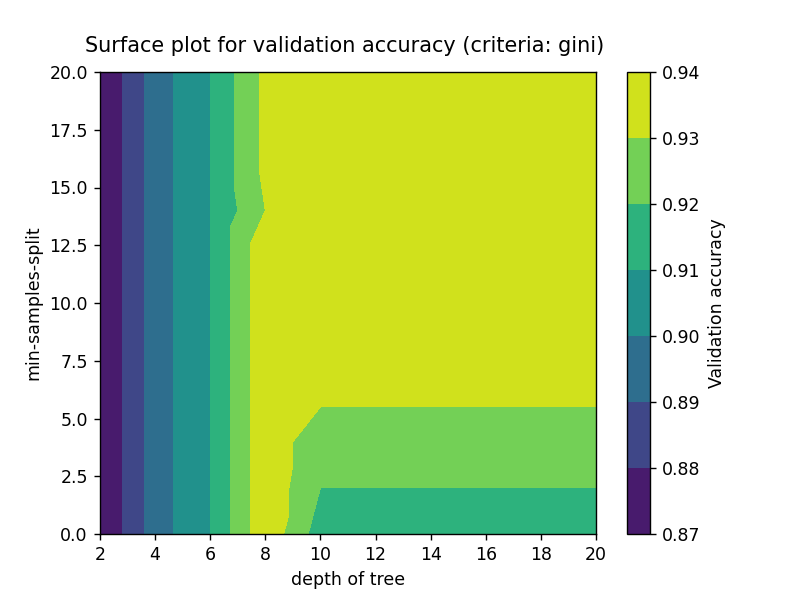

In [32]:
%matplotlib notebook
plt.close()
plt.xlabel("depth of tree")
plt.ylabel("min-samples-split")
plt.title("Surface plot for validation accuracy (criteria: gini) ", y=1.02)
plt.tricontourf(d, s, val_acc)
plt.colorbar(label = "Validation accuracy")
plt.show()

<IPython.core.display.Javascript object>


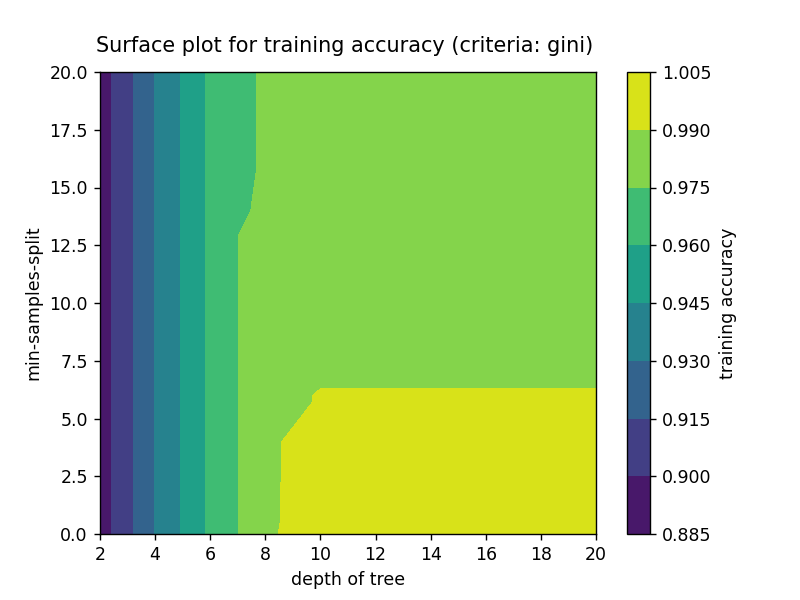

In [33]:
%matplotlib notebook
plt.close()
plt.xlabel("depth of tree")
plt.ylabel("min-samples-split")
plt.title("Surface plot for training accuracy (criteria: gini) ", y=1.02)
plt.tricontourf(d, s, train_acc)
plt.colorbar(label = "training accuracy")
plt.show()

In [34]:
d = []
s = []
train_acc = []
val_acc = []
for i in range(0,21,2):
    for j in range(2,21,2):
        d.append(j)
        s.append(i)
        t,v = evaluate(j, i, 'entropy')
        train_acc.append(t)
        val_acc.append(v)

Time taken to build tree: 0.8067224025726318 seconds
Train Accuracy: 0.90450, Train Precision: 0.80594, Train Recall: 0.81400
Validation Accuracy: 0.87500, Validation Precision: 0.76042, Validation Recall: 0.73000
Evaluation time for max_depth = 2, min_samples_split = 0 is 0.8067224025726318 seconds
Time taken to build tree: 2.01223087310791 seconds
Train Accuracy: 0.92350, Train Precision: 0.84631, Train Recall: 0.84800
Validation Accuracy: 0.89500, Validation Precision: 0.80208, Validation Recall: 0.77000
Evaluation time for max_depth = 4, min_samples_split = 0 is 2.0278615951538086 seconds
Time taken to build tree: 4.026665449142456 seconds
Train Accuracy: 0.96050, Train Precision: 0.89493, Train Recall: 0.95400
Validation Accuracy: 0.90250, Validation Precision: 0.78505, Validation Recall: 0.84000
Evaluation time for max_depth = 6, min_samples_split = 0 is 4.040598630905151 seconds
Time taken to build tree: 7.5760416984558105 seconds
Train Accuracy: 0.98900, Train Precision: 0.9649

Time taken to build tree: 8.644456148147583 seconds
Train Accuracy: 0.99800, Train Precision: 0.99799, Train Recall: 0.99400
Validation Accuracy: 0.92000, Validation Precision: 0.87778, Validation Recall: 0.79000
Evaluation time for max_depth = 18, min_samples_split = 4 is 8.66007375717163 seconds
Time taken to build tree: 9.241200923919678 seconds
Train Accuracy: 0.99800, Train Precision: 0.99799, Train Recall: 0.99400
Validation Accuracy: 0.92000, Validation Precision: 0.87778, Validation Recall: 0.79000
Evaluation time for max_depth = 20, min_samples_split = 4 is 9.262080669403076 seconds
Time taken to build tree: 0.847571849822998 seconds
Train Accuracy: 0.90450, Train Precision: 0.80594, Train Recall: 0.81400
Validation Accuracy: 0.87500, Validation Precision: 0.76042, Validation Recall: 0.73000
Evaluation time for max_depth = 2, min_samples_split = 6 is 0.8597023487091064 seconds
Time taken to build tree: 2.0109517574310303 seconds
Train Accuracy: 0.92350, Train Precision: 0.8463

Time taken to build tree: 7.329996585845947 seconds
Train Accuracy: 0.98900, Train Precision: 0.96498, Train Recall: 0.99200
Validation Accuracy: 0.90750, Validation Precision: 0.78899, Validation Recall: 0.86000
Evaluation time for max_depth = 14, min_samples_split = 10 is 7.34561824798584 seconds
Time taken to build tree: 6.915810823440552 seconds
Train Accuracy: 0.98900, Train Precision: 0.96498, Train Recall: 0.99200
Validation Accuracy: 0.90750, Validation Precision: 0.78899, Validation Recall: 0.86000
Evaluation time for max_depth = 16, min_samples_split = 10 is 6.931429386138916 seconds
Time taken to build tree: 7.220993518829346 seconds
Train Accuracy: 0.98900, Train Precision: 0.96498, Train Recall: 0.99200
Validation Accuracy: 0.90750, Validation Precision: 0.78899, Validation Recall: 0.86000
Evaluation time for max_depth = 18, min_samples_split = 10 is 7.236573934555054 seconds
Time taken to build tree: 7.2966697216033936 seconds
Train Accuracy: 0.98900, Train Precision: 0.9

Time taken to build tree: 5.474250555038452 seconds
Train Accuracy: 0.98150, Train Precision: 0.98737, Train Recall: 0.93800
Validation Accuracy: 0.91500, Validation Precision: 0.83673, Validation Recall: 0.82000
Evaluation time for max_depth = 10, min_samples_split = 16 is 5.491204500198364 seconds
Time taken to build tree: 5.398165225982666 seconds
Train Accuracy: 0.98150, Train Precision: 0.98737, Train Recall: 0.93800
Validation Accuracy: 0.91500, Validation Precision: 0.83673, Validation Recall: 0.82000
Evaluation time for max_depth = 12, min_samples_split = 16 is 5.414120197296143 seconds
Time taken to build tree: 5.260731935501099 seconds
Train Accuracy: 0.98150, Train Precision: 0.98737, Train Recall: 0.93800
Validation Accuracy: 0.91500, Validation Precision: 0.83673, Validation Recall: 0.82000
Evaluation time for max_depth = 14, min_samples_split = 16 is 5.276689529418945 seconds
Time taken to build tree: 5.591552495956421 seconds
Train Accuracy: 0.98150, Train Precision: 0.9

<IPython.core.display.Javascript object>


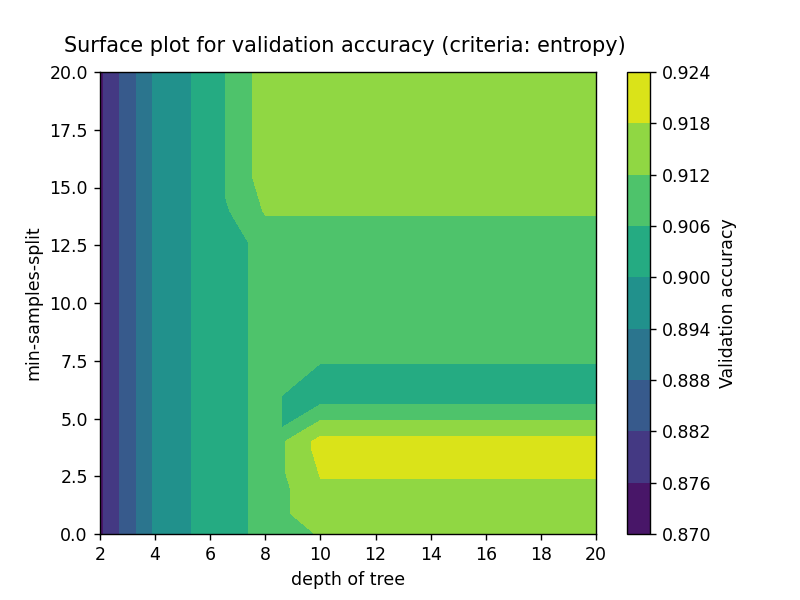

In [35]:
%matplotlib notebook
plt.close()
plt.xlabel("depth of tree")
plt.ylabel("min-samples-split")
plt.title("Surface plot for validation accuracy (criteria: entropy) ", y=1.02)
plt.tricontourf(d, s, val_acc)
plt.colorbar(label = "Validation accuracy")
plt.show()

<IPython.core.display.Javascript object>


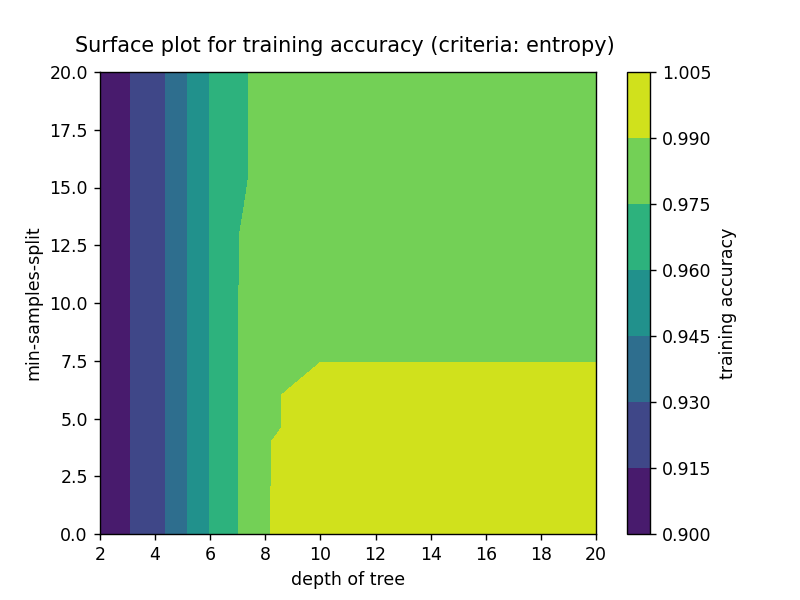

In [36]:
%matplotlib notebook
plt.close()
plt.xlabel("depth of tree")
plt.ylabel("min-samples-split")
plt.title("Surface plot for training accuracy (criteria: entropy) ", y=1.02)
plt.tricontourf(d, s, train_acc)
plt.colorbar(label = "training accuracy")
plt.show()

## Decision Tree using Sci-kit

In [17]:
def evaluate_sklearn(max_depth = 10, min_splitting = 7, criteria = 'gini', plot = False):
    start = time.time()
    clf = DecisionTreeClassifier(max_depth = max_depth, criterion = criteria, min_samples_split = min_splitting)
    clf = clf.fit(X_train,y_train)
    y = clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    
    # Train predictions
    train_acc = accuracy_score(y_train.ravel(), y)
    train_precision = precision_score(y_train.ravel(), y)
    train_recall = recall_score(y_train.ravel(), y)

    # Validation predictions
    val_acc = accuracy_score(y_val.ravel(), y_pred_val)
    val_precision = precision_score(y_val.ravel(), y_pred_val)
    val_recall = recall_score(y_val.ravel(), y_pred_val)

    print(f"Train Accuracy: {train_acc:.5f}, Train Precision: {train_precision:.5f}, Train Recall: {train_recall:.5f}")
    print(f"Validation Accuracy: {val_acc:.5f}, Validation Precision: {val_precision:.5f}, Validation Recall: {val_recall:.5f}")
    print(f'Evaluation time for max_depth = {max_depth}, min_samples_split = {min_splitting} is {time.time() - start} seconds')
    
    if(plot):
        com = confusion_matrix(y_val, y_pred_val, labels = [0,1])
        disp = ConfusionMatrixDisplay(com)
        disp.plot()
        name = "./img/bin_cm_d"+str(max_depth)+"_g"+str(min_splitting)+"_"+criteria+"_.png"
        plt.savefig(name)
        
    return train_acc, val_acc

### Gini

In [48]:
d = []
s = []
train_acc = []
val_acc = []
for i in range(2,21,2):
    for depth in range(2,21,2):
        d.append(depth)
        s.append(i)
        t,v = evaluate_sklearn(depth, i, 'gini')
        train_acc.append(t)
        val_acc.append(v)

Train Accuracy: 0.90400, Train Precision: 0.82906, Train Recall: 0.77600
Validation Accuracy: 0.88500, Validation Precision: 0.78125, Validation Recall: 0.75000
Evaluation time for max_depth = 2, min_samples_split = 2 is 0.9884538650512695 seconds
Train Accuracy: 0.96700, Train Precision: 0.93927, Train Recall: 0.92800
Validation Accuracy: 0.92500, Validation Precision: 0.86458, Validation Recall: 0.83000
Evaluation time for max_depth = 4, min_samples_split = 2 is 1.9811489582061768 seconds
Train Accuracy: 0.98800, Train Precision: 1.00000, Train Recall: 0.95200
Validation Accuracy: 0.92750, Validation Precision: 0.89888, Validation Recall: 0.80000
Evaluation time for max_depth = 6, min_samples_split = 2 is 2.9441418647766113 seconds
Train Accuracy: 0.99150, Train Precision: 0.99794, Train Recall: 0.96800
Validation Accuracy: 0.93250, Validation Precision: 0.90110, Validation Recall: 0.82000
Evaluation time for max_depth = 8, min_samples_split = 2 is 3.5354623794555664 seconds
Train Ac

Train Accuracy: 0.98700, Train Precision: 0.98367, Train Recall: 0.96400
Validation Accuracy: 0.92750, Validation Precision: 0.90805, Validation Recall: 0.79000
Evaluation time for max_depth = 10, min_samples_split = 8 is 2.5478224754333496 seconds
Train Accuracy: 0.98800, Train Precision: 0.98374, Train Recall: 0.96800
Validation Accuracy: 0.91250, Validation Precision: 0.84946, Validation Recall: 0.79000
Evaluation time for max_depth = 12, min_samples_split = 8 is 3.123995065689087 seconds
Train Accuracy: 0.98950, Train Precision: 0.97996, Train Recall: 0.97800
Validation Accuracy: 0.91750, Validation Precision: 0.84536, Validation Recall: 0.82000
Evaluation time for max_depth = 14, min_samples_split = 8 is 3.288374185562134 seconds
Train Accuracy: 0.99050, Train Precision: 0.98004, Train Recall: 0.98200
Validation Accuracy: 0.92000, Validation Precision: 0.86170, Validation Recall: 0.81000
Evaluation time for max_depth = 16, min_samples_split = 8 is 3.348848581314087 seconds
Train A

Train Accuracy: 0.98900, Train Precision: 0.97992, Train Recall: 0.97600
Validation Accuracy: 0.92750, Validation Precision: 0.89011, Validation Recall: 0.81000
Evaluation time for max_depth = 16, min_samples_split = 14 is 3.451091766357422 seconds
Train Accuracy: 0.98950, Train Precision: 0.97996, Train Recall: 0.97800
Validation Accuracy: 0.91750, Validation Precision: 0.86022, Validation Recall: 0.80000
Evaluation time for max_depth = 18, min_samples_split = 14 is 3.491351366043091 seconds
Train Accuracy: 0.98800, Train Precision: 0.97984, Train Recall: 0.97200
Validation Accuracy: 0.93000, Validation Precision: 0.89130, Validation Recall: 0.82000
Evaluation time for max_depth = 20, min_samples_split = 14 is 3.5034334659576416 seconds
Train Accuracy: 0.90400, Train Precision: 0.82906, Train Recall: 0.77600
Validation Accuracy: 0.88500, Validation Precision: 0.78125, Validation Recall: 0.75000
Evaluation time for max_depth = 2, min_samples_split = 16 is 0.6077027320861816 seconds
Tra

<IPython.core.display.Javascript object>


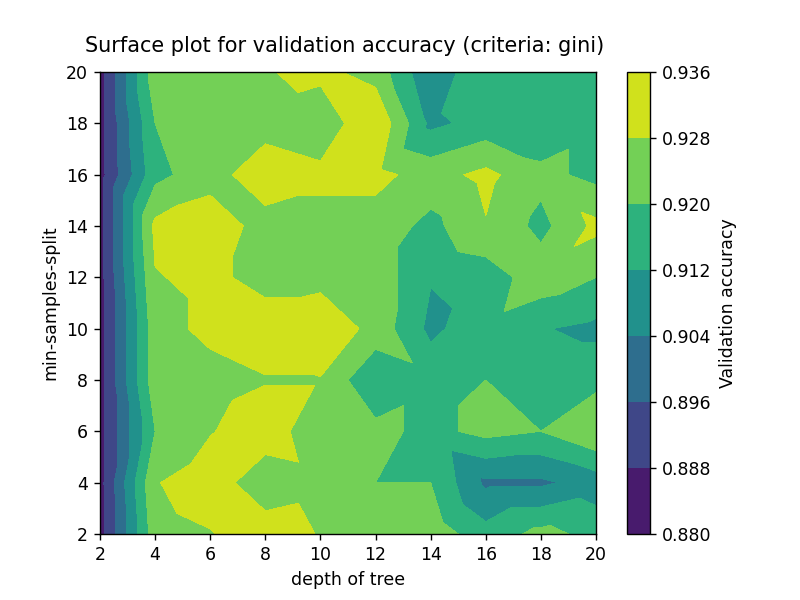

In [49]:
%matplotlib notebook
plt.close()
plt.xlabel("depth of tree")
plt.ylabel("min-samples-split")
plt.title("Surface plot for validation accuracy (criteria: gini) ", y=1.02)
plt.tricontourf(d, s, val_acc)
plt.colorbar(label = "Validation accuracy")
plt.show()

<IPython.core.display.Javascript object>


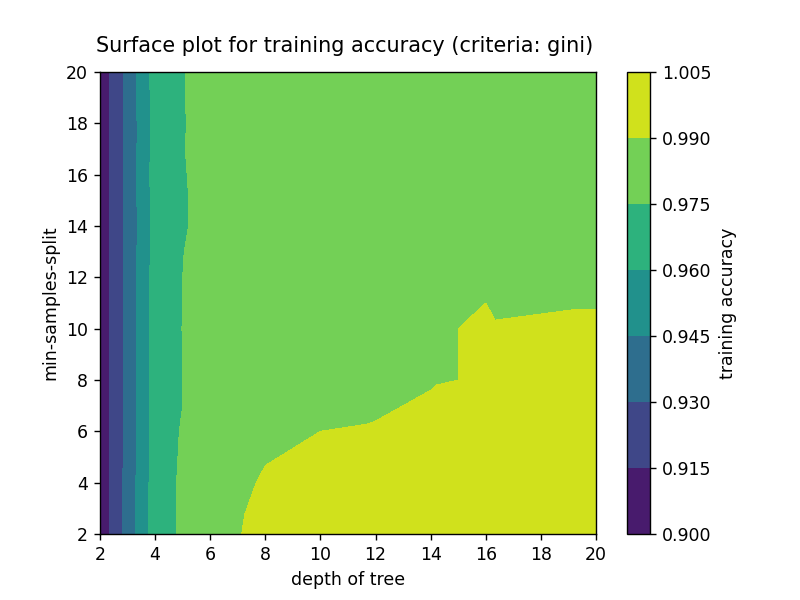

In [50]:
%matplotlib notebook
plt.close()
plt.xlabel("depth of tree")
plt.ylabel("min-samples-split")
plt.title("Surface plot for training accuracy (criteria: gini) ", y=1.02)
plt.tricontourf(d, s, train_acc)
plt.colorbar(label = "training accuracy")
plt.show()

### entropy

In [51]:
d = []
s = []
train_acc = []
val_acc = []
for i in range(2,21,2):
    for depth in range(5,21,2):
        d.append(depth)
        s.append(i)
        t,v = evaluate_sklearn(depth, i, 'entropy')
        train_acc.append(t)
        val_acc.append(v)

Train Accuracy: 0.98550, Train Precision: 0.96086, Train Recall: 0.98200
Validation Accuracy: 0.93500, Validation Precision: 0.84906, Validation Recall: 0.90000
Evaluation time for max_depth = 5, min_samples_split = 2 is 2.6136224269866943 seconds
Train Accuracy: 1.00000, Train Precision: 1.00000, Train Recall: 1.00000
Validation Accuracy: 0.94750, Validation Precision: 0.89109, Validation Recall: 0.90000
Evaluation time for max_depth = 7, min_samples_split = 2 is 2.8649425506591797 seconds
Train Accuracy: 1.00000, Train Precision: 1.00000, Train Recall: 1.00000
Validation Accuracy: 0.94250, Validation Precision: 0.86667, Validation Recall: 0.91000
Evaluation time for max_depth = 9, min_samples_split = 2 is 2.8417868614196777 seconds
Train Accuracy: 1.00000, Train Precision: 1.00000, Train Recall: 1.00000
Validation Accuracy: 0.94250, Validation Precision: 0.86667, Validation Recall: 0.91000
Evaluation time for max_depth = 11, min_samples_split = 2 is 2.826289653778076 seconds
Train Ac

Train Accuracy: 0.99800, Train Precision: 0.99206, Train Recall: 1.00000
Validation Accuracy: 0.93500, Validation Precision: 0.84259, Validation Recall: 0.91000
Evaluation time for max_depth = 7, min_samples_split = 10 is 1.71671462059021 seconds
Train Accuracy: 0.99800, Train Precision: 0.99206, Train Recall: 1.00000
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = 9, min_samples_split = 10 is 1.7217328548431396 seconds
Train Accuracy: 0.99800, Train Precision: 0.99206, Train Recall: 1.00000
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = 11, min_samples_split = 10 is 1.7421863079071045 seconds
Train Accuracy: 0.99800, Train Precision: 0.99206, Train Recall: 1.00000
Validation Accuracy: 0.94250, Validation Precision: 0.87379, Validation Recall: 0.90000
Evaluation time for max_depth = 13, min_samples_split = 10 is 1.7152841091156006 seconds
Trai

Train Accuracy: 0.99250, Train Precision: 0.99189, Train Recall: 0.97800
Validation Accuracy: 0.94250, Validation Precision: 0.86667, Validation Recall: 0.91000
Evaluation time for max_depth = 9, min_samples_split = 18 is 1.7187731266021729 seconds
Train Accuracy: 0.99250, Train Precision: 0.99189, Train Recall: 0.97800
Validation Accuracy: 0.94250, Validation Precision: 0.87379, Validation Recall: 0.90000
Evaluation time for max_depth = 11, min_samples_split = 18 is 1.745368242263794 seconds
Train Accuracy: 0.99250, Train Precision: 0.99189, Train Recall: 0.97800
Validation Accuracy: 0.94500, Validation Precision: 0.87500, Validation Recall: 0.91000
Evaluation time for max_depth = 13, min_samples_split = 18 is 1.726905107498169 seconds
Train Accuracy: 0.99250, Train Precision: 0.99189, Train Recall: 0.97800
Validation Accuracy: 0.93250, Validation Precision: 0.84762, Validation Recall: 0.89000
Evaluation time for max_depth = 15, min_samples_split = 18 is 1.8059325218200684 seconds
Tra

<IPython.core.display.Javascript object>


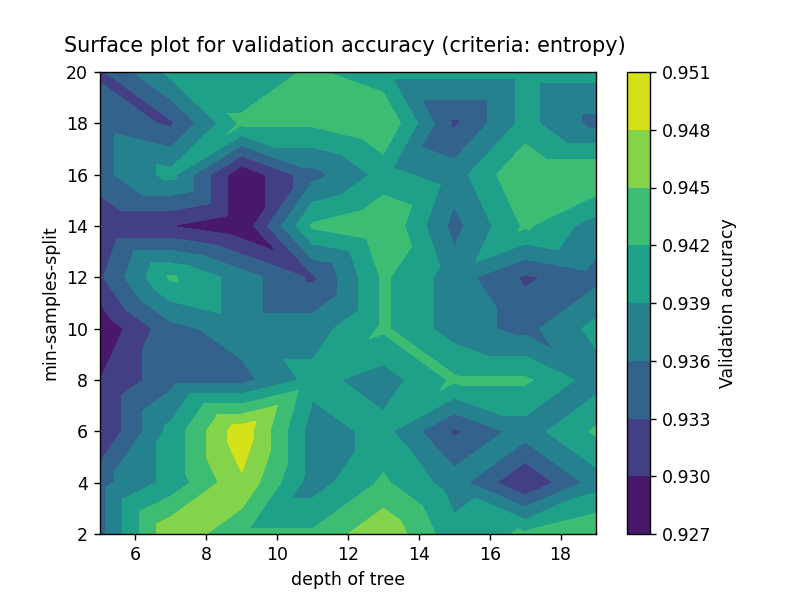

In [52]:
%matplotlib notebook
plt.close()
plt.xlabel("depth of tree")
plt.ylabel("min-samples-split")
plt.title("Surface plot for validation accuracy (criteria: entropy) ", y=1.02)
plt.tricontourf(d, s, val_acc)
plt.colorbar(label = "Validation accuracy")
plt.show()

<IPython.core.display.Javascript object>


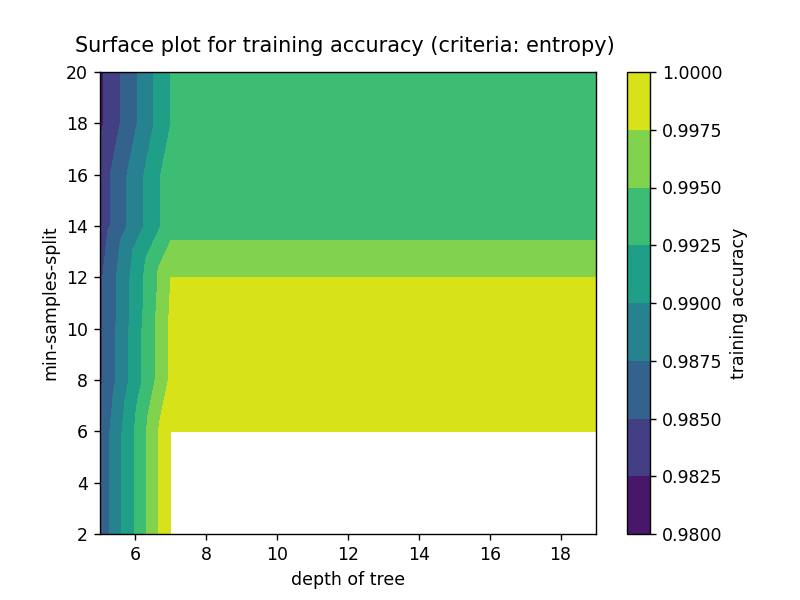

In [53]:
%matplotlib notebook
plt.close()
plt.xlabel("depth of tree")
plt.ylabel("min-samples-split")
plt.title("Surface plot for training accuracy (criteria: entropy) ", y=1.02)
plt.tricontourf(d, s, train_acc)
plt.colorbar(label = "training accuracy")
plt.show()

Time taken to build tree: 19.801544904708862 seconds
Train Accuracy: 0.98700, Train Precision: 0.96654, Train Recall: 0.98200
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = 10, min_samples_split = 7 is 19.832786083221436 seconds


<IPython.core.display.Javascript object>


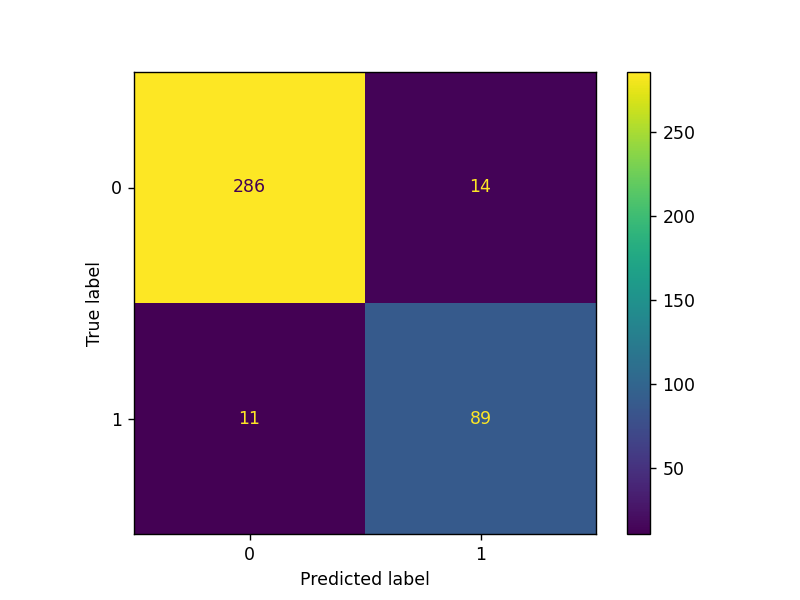

(0.987, 0.9375)

In [79]:
evaluate(criteria='gini', plot = True)

Time taken to build tree: 7.282720565795898 seconds
Train Accuracy: 0.98950, Train Precision: 0.96869, Train Recall: 0.99000
Validation Accuracy: 0.90500, Validation Precision: 0.78704, Validation Recall: 0.85000
Evaluation time for max_depth = 10, min_samples_split = 7 is 7.3056230545043945 seconds


<IPython.core.display.Javascript object>


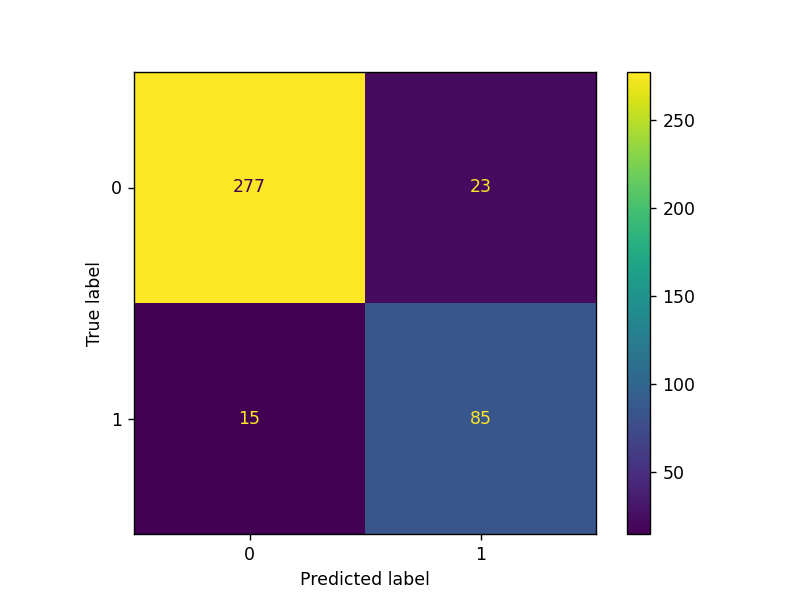

(0.9895, 0.905)

In [80]:
evaluate(criteria='entropy', plot = True)

## Decision Tree grid search

In [17]:
dtc = DecisionTreeClassifier()

# Define the grid search parameters
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 7, 10, 15],
    'min_samples_split': [2, 4, 7, 9]
}

# Perform the grid search with 5-fold cross-validation
grid_search = GridSearchCV(dtc, params, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Best score: 0.9359999999999999


In [20]:
evaluate_sklearn(10,2,criteria='entropy')

Train Accuracy: 1.00000, Train Precision: 1.00000, Train Recall: 1.00000
Validation Accuracy: 0.94000, Validation Precision: 0.86538, Validation Recall: 0.90000
Evaluation time for max_depth = 10, min_samples_split = 2 is 1.726489782333374 seconds


(1.0, 0.94)

In [23]:
tree = DecisionTreeClassifier(max_depth = 10, criterion = 'entropy', min_samples_split = 7)
tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, out_file=None,
                               feature_names = [i for i in range(0, X_train.shape[1])],
                               class_names=['0', '1'],
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph.view()

'Source.gv.pdf'

In [13]:
X_comb = np.vstack((X_train, X_val))
y_comb = np.vstack((y_train, y_val))
X_new = SelectKBest(mutual_info_regression, k=10).fit_transform(X_comb, np.ravel(y_comb))


X_train_new = X_new[0:len(X_train),:]
X_val_new = X_new[len(X_train):,:]

In [15]:
dtc = DecisionTreeClassifier()

# Define the grid search parameters
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 7, 10, 15],
    'min_samples_split': [2, 4, 7, 9]
}

# Perform the grid search with 5-fold cross-validation
grid_search = GridSearchCV(dtc, params, cv=5)
grid_search.fit(X_train_new, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 9}
Best score: 0.869


In [18]:
evaluate_sklearn(5,9,'entropy')

Train Accuracy: 0.98450, Train Precision: 0.95712, Train Recall: 0.98200
Validation Accuracy: 0.93250, Validation Precision: 0.83486, Validation Recall: 0.91000
Evaluation time for max_depth = 5, min_samples_split = 9 is 1.5942237377166748 seconds


(0.9845, 0.9325)

In [19]:
tree = DecisionTreeClassifier(max_depth = 5, criterion = 'entropy', min_samples_split = 9)
tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, out_file=None,
                               feature_names = [i for i in range(0, X_train.shape[1])],
                               class_names=['0', '1'],
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph.view()

'Source.gv.pdf'

### self implemented decision tree grid search

In [21]:
T = decisionTree()

# Define the grid search parameters
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 7, 10, 15],
    'min_samples_split': [2, 4, 7, 9]
}

# Perform the grid search with 5-fold cross-validation
grid_search = GridSearchCV(T, params, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Time taken to build tree: 14.069422721862793 seconds
Time taken to build tree: 23.35188937187195 seconds
Time taken to build tree: 27.78946828842163 seconds
Time taken to build tree: 25.329966068267822 seconds
Time taken to build tree: 23.642009973526 seconds
Time taken to build tree: 12.265682220458984 seconds
Time taken to build tree: 19.974242687225342 seconds
Time taken to build tree: 23.996745109558105 seconds
Time taken to build tree: 22.15475296974182 seconds
Time taken to build tree: 21.389058351516724 seconds
Time taken to build tree: 10.875163316726685 seconds
Time taken to build tree: 18.798755168914795 seconds
Time taken to build tree: 21.52654218673706 seconds
Time taken to build tree: 20.83881425857544 seconds
Time taken to build tree: 20.305550575256348 seconds
Time taken to build tree: 10.109436511993408 seconds
Time taken to build tree: 18.58695888519287 seconds
Time taken to build tree: 20.76068377494812 seconds
Time taken to build tree: 19.852569341659546 seconds
Tim

Time taken to build tree: 6.379289865493774 seconds
Time taken to build tree: 6.2329347133636475 seconds
Time taken to build tree: 6.237616777420044 seconds
Time taken to build tree: 5.078459978103638 seconds
Time taken to build tree: 8.519848346710205 seconds
Time taken to build tree: 10.145763397216797 seconds
Time taken to build tree: 9.243340253829956 seconds
Time taken to build tree: 8.785112857818604 seconds
Time taken to build tree: 4.673725605010986 seconds
Time taken to build tree: 7.857764959335327 seconds
Time taken to build tree: 9.357482194900513 seconds
Time taken to build tree: 8.50401258468628 seconds
Time taken to build tree: 8.141310214996338 seconds
Time taken to build tree: 4.1445417404174805 seconds
Time taken to build tree: 7.330221176147461 seconds
Time taken to build tree: 8.321017742156982 seconds
Time taken to build tree: 7.7006919384002686 seconds
Time taken to build tree: 7.481091499328613 seconds
Time taken to build tree: 3.769289970397949 seconds
Time take

In [25]:
evaluate(7, 2, 'gini')

Time taken to build tree: 15.020226001739502 seconds
Train Accuracy: 0.97750, Train Precision: 0.96715, Train Recall: 0.94200
Validation Accuracy: 0.93250, Validation Precision: 0.89247, Validation Recall: 0.83000
Evaluation time for max_depth = 7, min_samples_split = 2 is 15.035897254943848 seconds


(0.9775, 0.9325)

In [40]:
T = decisionTree(7, 2, 'gini')
T.fit(X_train, y_train)
T.plot()
# dot_data = export_graphviz(T, out_file=None,
#                                feature_names = [i for i in range(0, X_train.shape[1])],
#                                class_names=['0', '1'],
#                                filled=True, rounded=True,
#                                special_characters=True)
# graph = graphviz.Source(dot_data)
# graph.view()

Time taken to build tree: 14.232415914535522 seconds


In [26]:
X_comb = np.vstack((X_train, X_val))
y_comb = np.vstack((y_train, y_val))
X_new = SelectKBest(mutual_info_regression, k=10).fit_transform(X_comb, np.ravel(y_comb))


X_train_new = X_new[0:len(X_train),:]
X_val_new = X_new[len(X_train):,:]

dtc = decisionTree()

# Define the grid search parameters
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 7, 10, 15],
    'min_samples_split': [2, 4, 7, 9]
}

# Perform the grid search with 5-fold cross-validation

grid_search = GridSearchCV(dtc, params, cv=5)
grid_search.fit(X_train_new, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Time taken to build tree: 0.1874551773071289 seconds
Time taken to build tree: 0.34093379974365234 seconds
Time taken to build tree: 0.35415077209472656 seconds
Time taken to build tree: 0.369708776473999 seconds
Time taken to build tree: 0.34204864501953125 seconds
Time taken to build tree: 0.17183446884155273 seconds
Time taken to build tree: 0.2701244354248047 seconds
Time taken to build tree: 0.28049731254577637 seconds
Time taken to build tree: 0.29319047927856445 seconds
Time taken to build tree: 0.2916908264160156 seconds
Time taken to build tree: 0.1249704360961914 seconds
Time taken to build tree: 0.18231868743896484 seconds
Time taken to build tree: 0.18745636940002441 seconds
Time taken to build tree: 0.21051979064941406 seconds
Time taken to build tree: 0.21090054512023926 seconds
Time taken to build tree: 0.11081695556640625 seconds
Time taken to build tree: 0.18404197692871094 seconds
Time taken to build tree: 0.18741583824157715 seconds
Time taken to build tree: 0.191005

Time taken to build tree: 0.05461478233337402 seconds
Time taken to build tree: 0.031233787536621094 seconds
Time taken to build tree: 0.046865224838256836 seconds
Time taken to build tree: 0.04686379432678223 seconds
Time taken to build tree: 0.03809404373168945 seconds
Time taken to build tree: 0.0541536808013916 seconds
Time taken to build tree: 0.07810616493225098 seconds
Time taken to build tree: 0.13477063179016113 seconds
Time taken to build tree: 0.1250145435333252 seconds
Time taken to build tree: 0.1356515884399414 seconds
Time taken to build tree: 0.12497067451477051 seconds
Time taken to build tree: 0.06248879432678223 seconds
Time taken to build tree: 0.09685969352722168 seconds
Time taken to build tree: 0.11608624458312988 seconds
Time taken to build tree: 0.10939240455627441 seconds
Time taken to build tree: 0.10434412956237793 seconds
Time taken to build tree: 0.046813249588012695 seconds
Time taken to build tree: 0.07814979553222656 seconds
Time taken to build tree: 0.

In [27]:
evaluate(None,9,'gini')

Time taken to build tree: 31.066925287246704 seconds
Train Accuracy: 0.98700, Train Precision: 0.96654, Train Recall: 0.98200
Validation Accuracy: 0.93750, Validation Precision: 0.86408, Validation Recall: 0.89000
Evaluation time for max_depth = None, min_samples_split = 9 is 31.08258843421936 seconds


(0.987, 0.9375)

In [38]:
# tree = decisionTree(max_depth = None, criterion = 'gini', min_samples_split = 9)
# tree.fit(X_train_new, y_train)

# dot_data = export_graphviz(tree, out_file=None,
#                                feature_names = [i for i in range(0, X_train_new.shape[1])],
#                                class_names=['0', '1'],
#                                filled=True, rounded=True,
#                                special_characters=True)
# graph = graphviz.Source(dot_data)
# graph.view()

### grid search over 10 best parameter

In [50]:
def visualize_tree(tree):
    """
    Visualize a decision tree using Graphviz.
    tree: the decision tree model.
    """
    dot_data = export_graphviz(tree, out_file=None,
                               feature_names = [i for i in range(0, X_train.shape[1])],
                               class_names=['0', '1'],
                               filled=True, rounded=True,
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

In [53]:
tree = DecisionTreeClassifier(max_depth = 10, criterion = 'entropy', min_samples_split = 7)
tree.fit(X_train, y_train)
graph = visualize_tree(tree)
graph.view()

'Source.gv.pdf'

In [56]:
tree = DecisionTreeClassifier(max_depth = 5, criterion = 'gini', min_samples_split = 9)
tree.fit(X_train_new, y_train)

dot_data = export_graphviz(tree, out_file=None,
                               feature_names = [i for i in range(0, X_train_new.shape[1])],
                               class_names=['0', '1'],
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph.view()

'Source.gv.pdf'

### Decision Tree Post Pruning with Cost Complexity Pruning

In [13]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

<IPython.core.display.Javascript object>


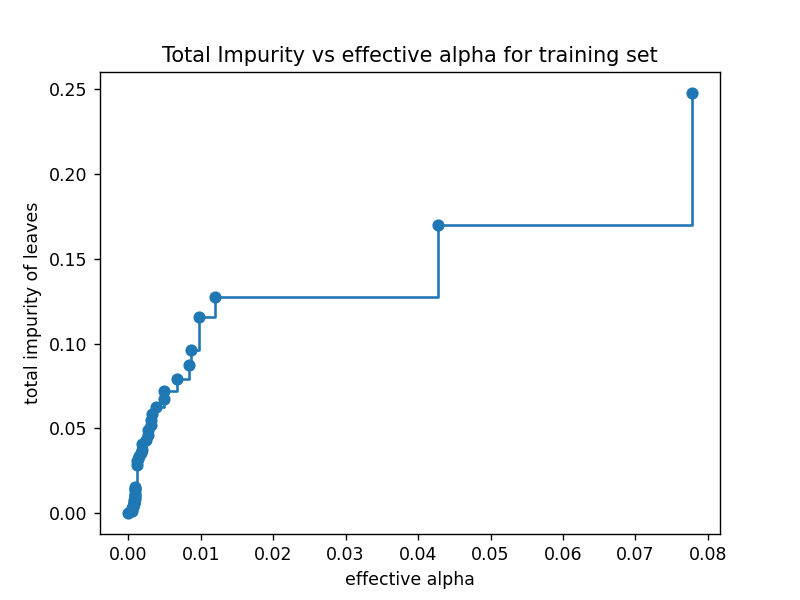

In [21]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [22]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(f"Number of nodes in the last tree is: {clfs[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

Number of nodes in the last tree is: 1 with ccp_alpha: 0.12714588355614


<IPython.core.display.Javascript object>


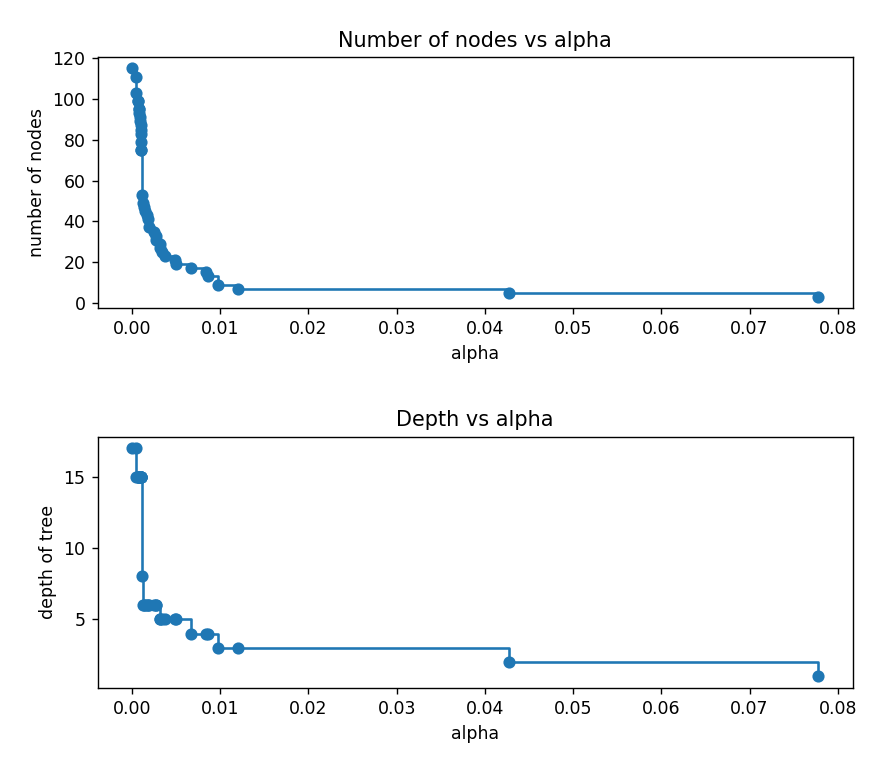

In [23]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

<IPython.core.display.Javascript object>


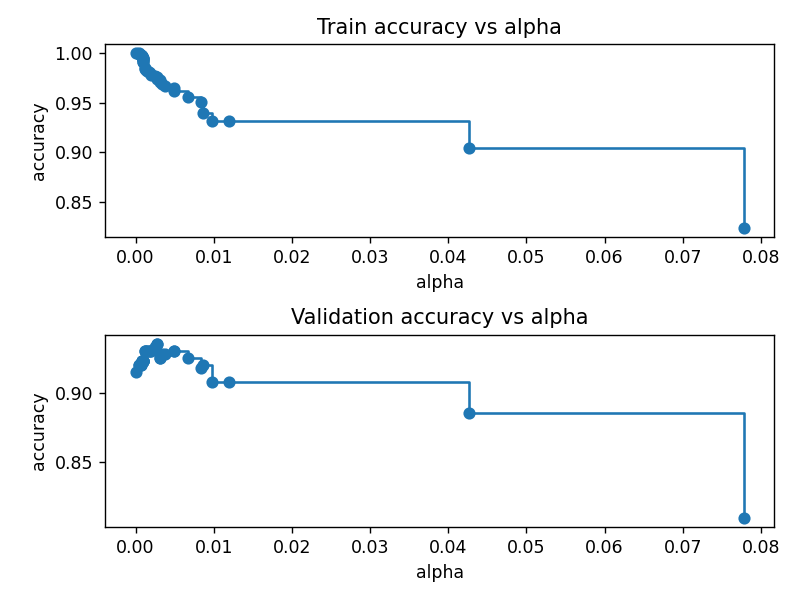

In [36]:
train_accuracy = [clf.score(X_train, y_train) for clf in clfs]
val_accuracy = [clf.score(X_val, y_val) for clf in clfs]
test_accuracy = [clf.score(X_test, y_test) for cls in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, train_accuracy, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Train accuracy vs alpha")
ax[1].plot(ccp_alphas, val_accuracy, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("accuracy")
ax[1].set_title("Validation accuracy vs alpha")
fig.tight_layout()

<IPython.core.display.Javascript object>


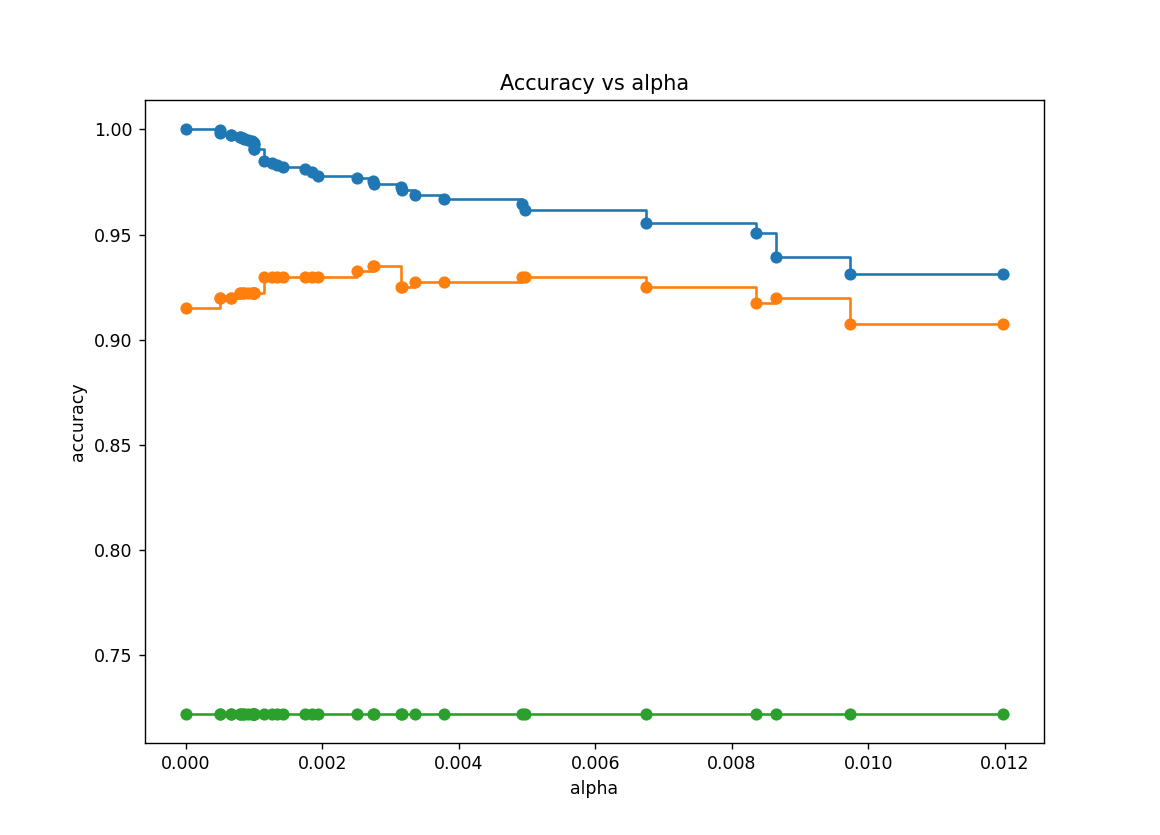

Text(0.5, 1.0, 'Accuracy vs alpha')

In [40]:
plt.plot(ccp_alphas[:-2], train_accuracy[:-2], marker="o", drawstyle="steps-post")
plt.plot(ccp_alphas[:-2], val_accuracy[:-2], marker="o", drawstyle="steps-post")
plt.plot(ccp_alphas[:-2], test_accuracy[:-2], marker="o", drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha")

In [41]:
test_accuracy

[0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222,
 0.7222222222222222]

In [ ]:
##ccp_alpha = 0.00273529

In [43]:
ccp_alphas

array([0.        , 0.00049693, 0.00049898, 0.00066667, 0.00066667,
       0.0008    , 0.0008    , 0.00083333, 0.00085714, 0.00090909,
       0.0009697 , 0.00098077, 0.00099324, 0.00099396, 0.001     ,
       0.001     , 0.00115083, 0.00125554, 0.00133333, 0.00142857,
       0.00175   , 0.00184824, 0.00193081, 0.00250414, 0.00273529,
       0.00276255, 0.00315844, 0.00316038, 0.00335463, 0.00378205,
       0.00492931, 0.00497143, 0.00673471, 0.00835346, 0.00864869,
       0.00972894, 0.01197279, 0.04270196, 0.07778015])

In [46]:
tree = DecisionTreeClassifier(random_state=0, ccp_alpha=0.00273529, criterion = 'gini')
tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, out_file=None,
                               feature_names = [i for i in range(0, X_train.shape[1])],
                               class_names=['0', '1'],
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph.view()

'Source.gv.pdf'

## Random Forest Classifier

In [51]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train.ravel())
y = clf.predict(X_train)
y_pred_val = clf.predict(X_val)

# Train predictions
train_acc = accuracy_score(y_train.ravel(), y)
train_precision = precision_score(y_train.ravel(), y)
train_recall = recall_score(y_train.ravel(), y)

# Validation predictions
val_acc = accuracy_score(y_val.ravel(), y_pred_val)
val_precision = precision_score(y_val.ravel(), y_pred_val)
val_recall = recall_score(y_val.ravel(), y_pred_val)

print(f"Train Accuracy: {train_acc:.5f}, Train Precision: {train_precision:.5f}, Train Recall: {train_recall:.5f}")
print(f"Validation Accuracy: {val_acc:.5f}, Validation Precision: {val_precision:.5f}, Validation Recall: {val_recall:.5f}")
# print(f'Evaluation time for max_depth = {max_depth}, min_samples_split = {min_splitting} is {time.time() - start} seconds')

Train Accuracy: 1.00000, Train Precision: 1.00000, Train Recall: 1.00000
Validation Accuracy: 0.97500, Validation Precision: 1.00000, Validation Recall: 0.90000


In [56]:
rfc = RandomForestClassifier()

# Define the grid search parameters
params = {
     'n_estimators': [80,100,150,200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None,5,7,10],
    'min_samples_split': [5,7,10]
}

# Perform the grid search with 5-fold cross-validation
grid_search = GridSearchCV(rfc, params, cv=5)
grid_search.fit(X_train, y_train.ravel())

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best score: 0.982


In [57]:
clf = RandomForestClassifier(criterion='entropy', min_samples_split= 5, n_estimators=100)
clf.fit(X_train, y_train.ravel())
y = clf.predict(X_train)
y_pred_val = clf.predict(X_val)

# Train predictions
train_acc = accuracy_score(y_train.ravel(), y)
train_precision = precision_score(y_train.ravel(), y)
train_recall = recall_score(y_train.ravel(), y)

# Validation predictions
val_acc = accuracy_score(y_val.ravel(), y_pred_val)
val_precision = precision_score(y_val.ravel(), y_pred_val)
val_recall = recall_score(y_val.ravel(), y_pred_val)

print(f"Train Accuracy: {train_acc:.5f}, Train Precision: {train_precision:.5f}, Train Recall: {train_recall:.5f}")
print(f"Validation Accuracy: {val_acc:.5f}, Validation Precision: {val_precision:.5f}, Validation Recall: {val_recall:.5f}")
# print(f'Evaluation time for max_depth = {max_depth}, min_samples_split = {min_splitting} is {time.time() - start} seconds')

Train Accuracy: 1.00000, Train Precision: 1.00000, Train Recall: 1.00000
Validation Accuracy: 0.98000, Validation Precision: 1.00000, Validation Recall: 0.92000


## Gradient Boosted Trees and XGBoost

In [ ]:
param_grid = {'n_estimators': [20, 30, 40, 50],
              'subsample': [0.2, 0.3, 0.4, 0.5, 0.6],
              'max_depth': [5, 6, 7, 8, 9, 10]}

gbc = GradientBoostingClassifier()

# Create Grid Search object
grid_search = GridSearchCV(gbc, param_grid, cv=5)

# Train and time the grid search
start_time = time.time()
grid_search.fit(X_train, y_train.ravel())
train_time = time.time() - start_time

# Get best parameters and best estimator
best_gbc = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

In [ ]:
# XGBoost

In [15]:
model = XGBClassifier(tree_method='exact')
model.fit(X_train, y_train)

# Make predictions
y = model.predict(X_train)
y_pred_val = model.predict(X_val)

# Train predictions
train_acc = accuracy_score(y_train.ravel(), y)
train_precision = precision_score(y_train.ravel(), y)
train_recall = recall_score(y_train.ravel(), y)

# Validation predictions
val_acc = accuracy_score(y_val.ravel(), y_pred_val)
val_precision = precision_score(y_val.ravel(), y_pred_val)
val_recall = recall_score(y_val.ravel(), y_pred_val)

print(f"Train Accuracy: {train_acc:.5f}, Train Precision: {train_precision:.5f}, Train Recall: {train_recall:.5f}")
print(f"Validation Accuracy: {val_acc:.5f}, Validation Precision: {val_precision:.5f}, Validation Recall: {val_recall:.5f}")
# print(f'Evaluation time for max_depth = {max_depth}, min_samples_split = {min_splitting} is {time.time() - start} seconds')

Train Accuracy: 1.00000, Train Precision: 1.00000, Train Recall: 1.00000
Validation Accuracy: 0.98750, Validation Precision: 1.00000, Validation Recall: 0.95000


In [28]:
model = XGBClassifier(tree_method='gpu_hist')
model.fit(X_train, y_train)

# Make predictions
y = model.predict(X_train)
y_pred_val = model.predict(X_val)

# Train predictions
train_acc = accuracy_score(y_train.ravel(), y)
train_precision = precision_score(y_train.ravel(), y)
train_recall = recall_score(y_train.ravel(), y)

# Validation predictions
val_acc = accuracy_score(y_val.ravel(), y_pred_val)
val_precision = precision_score(y_val.ravel(), y_pred_val)
val_recall = recall_score(y_val.ravel(), y_pred_val)

print(f"Train Accuracy: {train_acc:.5f}, Train Precision: {train_precision:.5f}, Train Recall: {train_recall:.5f}")
print(f"Validation Accuracy: {val_acc:.5f}, Validation Precision: {val_precision:.5f}, Validation Recall: {val_recall:.5f}")
# print(f'Evaluation time for max_depth = {max_depth}, min_samples_split = {min_splitting} is {time.time() - start} seconds')

XGBoostError: [22:34:22] c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\common\common.h:239: XGBoost version not compiled with GPU support.

In [27]:
param_grid = {'n_estimators': [20, 30, 40, 50],
              'subsample': [0.2, 0.3, 0.4, 0.5, 0.6],
              'max_depth': [5, 6, 7, 8, 9, 10]}

model = XGBClassifier(tree_method='exact')

# Create Grid Search object
grid_search = GridSearchCV(model, param_grid, cv=5)

# Train and time the grid search
start_time = time.time()
grid_search.fit(X_train, y_train.ravel())
train_time = time.time() - start_time

# Get best parameters and best estimator
best_gbc = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

KeyboardInterrupt: 

In [24]:
import xgboost as xgb
print(xgb.__version__)

1.7.3
